In [1]:
import cv2 as cv
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [2]:
def create_affine_transform_matrix(size,angle):
    return np.array([[np.cos(angle), -np.sin(angle), size[1]/2], [np.sin(angle), np.cos(angle), 0]])
def create_perspective_transform_matrix(size,angle):
    return np.vstack([create_affine_transform_matrix(size,angle),[0, 0, 1]])

((3840, 2160), 4, False)

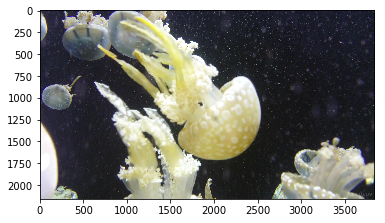

In [3]:
#http://jell.yfish.us/
vid_path = os.environ['USERPROFILE'] + '/Videos/jellyfish-120-mbps-4k-uhd-h264.mkv'
cap = cv.cudacodec.createVideoReader(vid_path)
stream = cv.cuda_Stream()
_,cuFrame = cap.nextFrame(stream = stream)
plt.imshow(cv.cuda.cvtColor(cuFrame,cv.COLOR_BGRA2RGBA).download());
cuFrame.size(),cuFrame.channels(),cuFrame.type == cv.CV_8UC4

In [4]:
borderMode = cv.BORDER_REFLECT101
flags = cv.WARP_INVERSE_MAP
dsize = cuFrame.size()
cuDst = cv.cuda_GpuMat(cuFrame.size(),cuFrame.type())
M = create_affine_transform_matrix(dsize,np.pi/3)
cv.cuda.warpAffine(cuFrame,M,dsize,dst=cuDst,flags=flags,borderMode=borderMode,stream=stream)
stream.waitForCompletion()

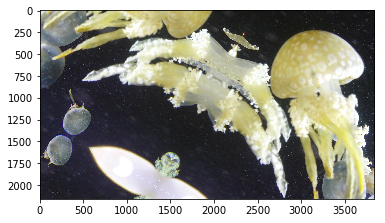

In [5]:
plt.imshow(cv.cuda.cvtColor(cuDst,cv.COLOR_BGRA2RGBA).download());

In [6]:
frame = cuFrame.download()

In [7]:
npDst = cv.warpAffine(frame,M,dsize,flags=flags,borderMode=borderMode)

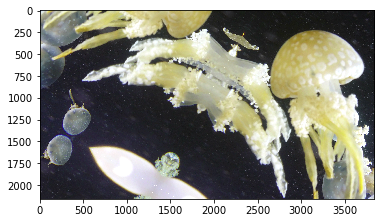

In [8]:
plt.imshow(cv.cvtColor(npDst,cv.COLOR_BGR2RGB));

In [9]:
%timeit npDst = cv.warpAffine(frame,M,dsize)

208 ms ± 8.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit cv.warpAffine(frame,M,dsize,npDst)

206 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit cuDst = cv.cuda.warpAffine(cuFrame,M,dsize)

2.39 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit cv.cuda.warpAffine(cuFrame,M,dsize,dst=cuDst)

957 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Tests for OpenCV

### warpAffine

In [13]:
borderType = cv.BORDER_REFLECT101
npMat = (np.random.random((128,128,3))*255).astype(np.uint8)
size = npMat.shape[:2]
# results differ from cv.warpAffine for most rotations see 
# https://github.com/opencv/opencv_contrib/blob/65abc7090dedc84bbedec4dfd143f0340e52114f/modules/cudawarping/test/test_warp_affine.cpp#L114
M = create_affine_transform_matrix(size,np.pi/2) 
cuMat = cv.cuda_GpuMat(npMat)
cuMatDst = cv.cuda_GpuMat(size,cuMat.type())

np.allclose(cv.cuda.warpAffine(cuMat,M,size,borderMode=borderType).download(),
            cv.warpAffine(npMat,M,size, borderMode=borderType))
cv.cuda.warpAffine(cuMat,M,size,cuMatDst,borderMode=borderType)
np.allclose(cuMatDst.download(),cv.warpAffine(npMat,M,size,borderMode=borderType))

True

In [14]:
interpolation = cv.INTER_NEAREST
flags = interpolation | cv.WARP_INVERSE_MAP
npMat = (np.random.random((128, 128, 3))*255).astype(np.uint8)
dst_gold = cv.warpAffine(npMat, M, size, flags = flags);
cuMaps = cv.cuda.buildWarpAffineMaps(M,True,size)
dst = cv.remap(npMat, cuMaps[0].download(), cuMaps[1].download(),interpolation);        
np.allclose(dst,dst_gold)

xmap = cv.cuda_GpuMat(size,cv.CV_32FC1)
ymap = cv.cuda_GpuMat(size,cv.CV_32FC1)
cv.cuda.buildWarpAffineMaps(M,True,size,xmap,ymap)
dst = cv.remap(npMat, xmap.download(), ymap.download(),interpolation);        
np.allclose(dst,dst_gold)

True

### warpPerspective

In [15]:
borderType = cv.BORDER_REFLECT101
npMat = (np.random.random((128,128,3))*255).astype(np.uint8)
size = npMat.shape[:2]
# results differ from cv.warpAffine for most rotations see 
# https://github.com/opencv/opencv_contrib/blob/65abc7090dedc84bbedec4dfd143f0340e52114f/modules/cudawarping/test/test_warp_perspective.cpp#L115
M = create_perspective_transform_matrix(size,np.pi/2) 
cuMat = cv.cuda_GpuMat(npMat)
cuMatDst = cv.cuda_GpuMat(size,cuMat.type())

np.allclose(cv.cuda.warpPerspective(cuMat,M,size,borderMode=borderType).download(),
            cv.warpPerspective(npMat,M,size,borderMode=borderType))
cv.cuda.warpPerspective(cuMat,M,size,cuMatDst,borderMode=borderType)
np.allclose(cuMatDst.download(),cv.warpPerspective(npMat,M,size,borderMode=borderType))

True

In [16]:
interpolation = cv.INTER_NEAREST
flags = interpolation | cv.WARP_INVERSE_MAP
npMat = (np.random.random((128, 128, 3))*255).astype(np.uint8)
dst_gold = cv.warpPerspective(npMat, M, size, flags = flags);
cuMaps = cv.cuda.buildWarpPerspectiveMaps(M,True,size)
dst = cv.remap(npMat, cuMaps[0].download(), cuMaps[1].download(),interpolation);        
np.allclose(dst,dst_gold)

xmap = cv.cuda_GpuMat(size,cv.CV_32FC1)
ymap = cv.cuda_GpuMat(size,cv.CV_32FC1)
cv.cuda.buildWarpPerspectiveMaps(M,True,size,xmap,ymap)
dst = cv.remap(npMat, xmap.download(), ymap.download(),interpolation);        
np.allclose(dst,dst_gold)

True